![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [17]:
# Celda 1.1
bikes.groupby('season')['total'].agg(['mean', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).round(2)

,mean,min,max,<lambda_0>,<lambda_1>
season,,,,,
1,116.34,1,801,24.0,164.0
2,215.25,1,873,49.0,321.0
3,234.42,1,977,68.0,347.0
4,198.99,1,948,51.0,294.0


In [18]:
# Celda 1.2
bikes.groupby('hour')['total'].agg(['mean', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).round(2)

,mean,min,max,<lambda_0>,<lambda_1>
hour,,,,,
0,55.14,2,283,24.00,74.50
1,33.86,1,168,11.00,46.00
2,22.90,1,119,5.00,32.00
3,11.76,1,66,3.00,15.00
4,6.41,1,28,3.00,9.00
5,19.77,1,57,8.00,29.00
6,76.26,1,213,24.50,118.00
7,213.12,1,596,63.00,334.00
8,362.77,8,839,133.50,563.50


Sobre la variable "Season" (Temporada), donde 1 es invierno, 2 es primavera, 3 es verano y 4 es otoño, se evidencia que en promedio durante el verano se rentan la mayor cantidad de bicicletas por hora (234 bicicletas); sin embargo, el 75% de las veces durante el verano se rentan 347 bicicletas o menos. Así mismo, durante el invierno se rentan la menor cantidad por hora (116 bicicletas), y el 75% de las veces durante esta temporada se rentan 164 bicicletas o menos. Se observa que, independientemente de la temporada, hay horas donde solo se renta una bicicleta en una hora. Mientras que en general, la cantidad máxima de bicicletas rentadas en una hora oscila entre 801 y 977.

Sobre la variable "Hour" (Hora), la cual corresponde a la hora del día, se observa que la hora en que más se alquila bicicletas es a las 6PM (mínimo 23, máximo 977 bicicletas por hora). Sin embargo, las 5PM presenta el promedio más alto de alquiler de bicicletas (468 por hora) y en el 75% de los casos, se rentan 608 o menos bicicletas. Así mismo, se observa que de 3AM a 5AM se presenta la mínima actividad de alquiler (Mínimo 1, Máximo 66 bicicletas por hora). Y en promedio a las 4AM se observa la menor actividad de alquiler (6 bicicletas) y en el 75% de los casos se rentan (9 o menos bicicletas por hora).

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

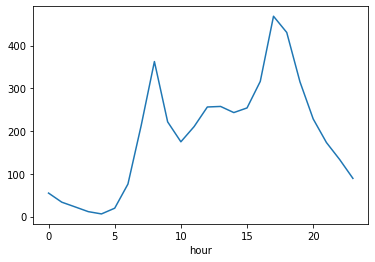

In [19]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

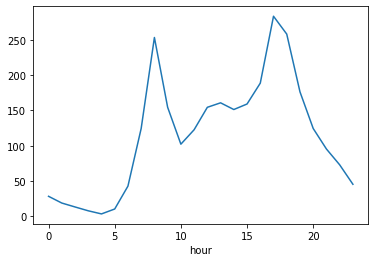

In [31]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes_winter = bikes.loc[bikes['season'] == 1]
bikes_winter.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

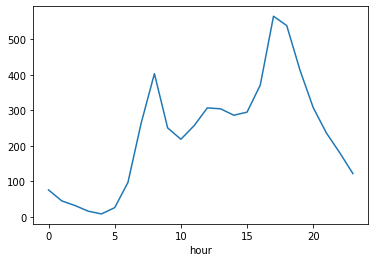

In [30]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes_summer = bikes.loc[bikes['season'] == 3]
bikes_summer.groupby('hour').total.mean().plot()

A partir de las tres gráficas, se observa que el comportamiento de la cantidad promedio de bicicletas rentadas por hora durante el transcurso del día es similar en todas las temporadas. Se observan tres picos de actividad, uno a las 8AM y a las 5PM (los más significativos) y también a la 1PM. Así mismo, se evidencia un valle de actividad durante la madrugada de 12PM a 5AM, cuando se dispara el primer pico de actividad.También se observa que después de las 6PM cae progresivamente la actividad de alquiler. Una de las diferencias más notable entre la actividad de alquiler entre la temporada de invierno y verano, es que los dos picos más significativos de actividad durante el verano son en promedio iguales (250 bicicletas por horas), mientras que en verano el primero pico a las 8AM es menor (400 bicicletas) que el de las 5PM (560 bicicletas).

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [44]:
# Celda 3

season = pd.get_dummies(bikes['season'])
hour = bikes.loc[:,'hour']

X = pd.concat([season.iloc[:,0:3], hour], axis=1)
y = bikes['total']
print(X)

reg = LinearRegression()
reg.fit(X, y)
print('Coeficientes:\n', reg.coef_)

                     1  2  3  hour
datetime                          
2011-01-01 00:00:00  1  0  0     0
2011-01-01 01:00:00  1  0  0     1
2011-01-01 02:00:00  1  0  0     2
2011-01-01 03:00:00  1  0  0     3
2011-01-01 04:00:00  1  0  0     4
...                 .. .. ..   ...
2012-12-19 19:00:00  0  0  0    19
2012-12-19 20:00:00  0  0  0    20
2012-12-19 21:00:00  0  0  0    21
2012-12-19 22:00:00  0  0  0    22
2012-12-19 23:00:00  0  0  0    23

[10886 rows x 4 columns]
Coeficientes:
 [-84.08311787  16.23411404  35.38443207  10.54520609]


Dado que la variable "Season" es categorica, se procede a obtener un set de datos dummy de la varaible, donde solo se incluyen 3 de las cuatro varaible dummies para evitar problemas de multicolinealidad, luego se procede a ajustar un modelos de regresion lineal a todo el el conjunto de datos, para obtener los siguientes coeficientes:

- El coeficiente de -84.08 para la variable dummy "1" es decir es invierno, indica que, en promedio, durante el invierno se alquilan 84.08 bicicletas menos por hora que durante las otras estaciones del año, manteniendo constante la hora del día.

- El coeficiente de 16.23 para la variable dummy "2" es decir es primavera, indica que, en promedio, durante la primavera se alquilan 16.23 bicicletas más por hora que durante las otras estaciones del año, manteniendo constante la hora del día.

- El coeficiente de 35.38 para la variable dummy "3" es decir es verano, indica que, en promedio, durante el verano se alquilan 35.38 bicicletas más por hora que durante las otras estaciones del año, manteniendo constante la hora del día y otras variables predictoras.

- El coeficiente de 10.54 para la variable "hour" indica que, en promedio, por cada hora más que pasa del día (de 0 a 23), se alquilan 10.54 bicicletas más por hora, manteniendo constante la estación del año.

Con respecto a las limitaciones de la regresión lineal, dado que la variable season es categórica, y con el fin de evitar la multicolinealidad se retiró la variable dummy que toma el valor de 1 cuando es otoño, no se obtuvo coeficiente para explicar la relación de la estación otoño con la cantidad de bicicletas rentadas. Y sobre la variable hour, el modelo no puede capturar las fluctuaciones que se evidencian durante el día. Como resultado, se asume que la cantidad de bicicletas rentadas siempre aumenta durante el transcurso del día, lo cual no es preciso.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [106]:
# Celda 4

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])   
    best_split = [0, 0, 0]  # j, split, gain
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)           
            if gain > best_split[2]:
                best_split = [j, split, gain]
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree 
    # Verificar si los nodos hijos no son nulos
    if 'sl' in tree and 'sr' in tree:
        if tree['sl'] is not None and tree['sr'] is not None:
            if tree['sl']['n_samples'] + tree['sr']['n_samples'] < 6:  # Verificar el número mínimo de nodos finales
                return tree
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    predicted = np.ones(X.shape[0])
    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']    
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
    return predicted

In [108]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X_train, y_train, 5)

# Aplicación de la función tree_grow
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=10)

# Ejecución de función tree_predict
tree_predict(X_test, tree)

array([0., 0., 0., ..., 0., 1., 0.])

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

(12755.42913740627, 8)

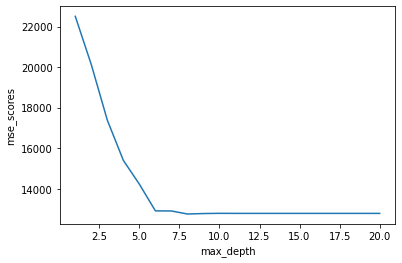

In [73]:
# Celda 5

from sklearn.model_selection import cross_val_score

max_depth_range = range(1, 21)
mse_scores = []

for depth in max_depth_range:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    mse = -1 * cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean()
    mse_scores.append(mse)

plt.plot(max_depth_range, mse_scores)
plt.xlabel('max_depth')
plt.ylabel('mse_scores')

# Mejor MSE (desempeño del modelo) y su correspondiente max_depth
sorted(zip(mse_scores, max_depth_range))[::1][0]

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

clf = DecisionTreeRegressor(max_depth=8, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE): ", mse)
print("R-squared (R2): ", r2)

Mean Squared Error (MSE):  13698.232540452216
R-squared (R2):  0.5768294097187254


In [72]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE): ", mse)
print("R-squared (R2): ", r2)

Mean Squared Error (MSE):  25366.611967658602
R-squared (R2):  0.21636575170625916


Después de entrenar un árbol de decisiones con la librería sklearn, y calibrar la profundidad máxima del árbol, se obtiene que un árbol con 8 niveles de profundidad presenta el mejor desempeño al arrojar un MSE de 12755.42. Así mismo se observa que el modelo tiene un R2 de 0.57, mientras que un modelo de regresión lineal tienen un menor desempeñó con un MSE mayor de 25366.61 y un R2 inferior de 0.21, es decir, el modelo solo explica el 21% de la variabilidad de los datos observados.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [75]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [76]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [77]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

(0.6353333333333333, 2)

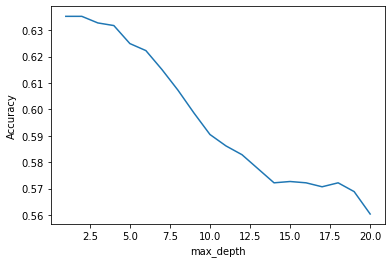

In [79]:
# Celda 6

max_depth_range = range(1, 21)
accuracy_scores = []

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

In [81]:
from sklearn.metrics import accuracy_score, f1_score

clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", acc)
print("F1-Score:", f1)

Accuracy: 0.6453333333333333
F1-Score: 0.6453289196958572


In [84]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", acc)
print("F1-Score:", f1)

Accuracy: 0.614
F1-Score: 0.6139565941101721


Después de construir un árbol de decisión y calibrarlo a través de la profundidad, se obtiene un modelo con una Accuracy y F1-Score de 0.645 y 0.645 respectivamente, es decir, el modelo está acertando correctamente alrededor del 64% de las veces. En otras palabras, aproximadamente 6 de cada 10 predicciones son correctas. Por su parte, también se entrenó un modelo de regresión logística, con el cual se obtuvo una Accuracy y F1-Score de 0.614 y 0.613 respectivamente. De forma que se puede concluir que un modelo de árbol de decisión tiene mayor capacidad de predicción para este set de datos.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [96]:
# Modelo 1: 100 Decision Trees with max_depth
modelo1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Modelo 2: 100 Decision Trees with min_samples_leaf
modelo2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=5), n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Modelo 3: 100 Logistic Regressions
modelo3 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Entrenar y evaluar Modelo 1
modelo1.fit(X_train, y_train)
y_pred1 = modelo1.predict(X_test)
acc1 = accuracy_score(y_test, y_pred1)
f1_1 = f1_score(y_test, y_pred1)

# Entrenar y evaluar Modelo 2
modelo2.fit(X_train, y_train)
y_pred2 = modelo2.predict(X_test)
acc2 = accuracy_score(y_test, y_pred2)
f1_2 = f1_score(y_test, y_pred2)

# Entrenar y evaluar Modelo 3
modelo3.fit(X_train, y_train)
y_pred3 = modelo3.predict(X_test)
acc3 = accuracy_score(y_test, y_pred3)
f1_3 = f1_score(y_test, y_pred3)

# Imprimir resultados modelos individuales
print("Modelo 1 Accuracy: ", acc1)
print("Modelo 1 F1-Score: ", f1_1)
print("Modelo 2 Accuracy: ", acc2)
print("Modelo 2 F1-Score: ", f1_2)
print("Modelo 3 Accuracy: ", acc3)
print("Modelo 3 F1-Score: ", f1_3)

# crear ensamble
ensamble = VotingClassifier(estimators=[('dt_max', modelo1), 
                                        ('dt_min', modelo2), 
                                        ('logreg', modelo3)],
                             voting='hard')

# Entrenar y evaluar ensamble
ensamble.fit(X_train, y_train)
y_pred_ensamble = ensamble.predict(X_test)
acc_ensamble = accuracy_score(y_test, y_pred_ensamble)
f1_ensamble = f1_score(y_test, y_pred_ensamble)

# Imprimier resultado ensamble
print("Ensamble Accuracy: ", acc_ensamble)
print("Ensamble F1-Score: ", f1_ensamble)


Modelo 1 Accuracy:  0.6446666666666667
Modelo 1 F1-Score:  0.6376614547926581
Modelo 2 Accuracy:  0.6553333333333333
Modelo 2 F1-Score:  0.6582947785855915
Modelo 3 Accuracy:  0.618
Modelo 3 F1-Score:  0.6136210384356034
Ensamble Accuracy:  0.6446666666666667
Ensamble F1-Score:  0.6396213657876945


Después de entrenar cada uno de los tres escenarios propuestos y evaluar cada uno por separado mediante el porcentaje de accuracy y F1, se observa que el escenario de 100 árboles de decisión donde min_samples_leaf es 5, presenta el mejor desempeño con 0.65 de accruacy y F1. Una vez se construye el ensamblaje considerando los modelos de los 3 escenarios mediante votacion mayoritaria, se obtiene un desempeño un poco inferior al modelo anteriormente mencionado, su accruacy y F1 son cercanos a 0.64.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [99]:
# Modelo 1: 100 Decision Trees with max_depth
modelo1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Modelo 2: 100 Decision Trees with min_samples_leaf
modelo2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=5), n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Modelo 3: 100 Logistic Regressions
modelo3 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Entrenar y evaluar Modelo 1
modelo1.fit(X_train, y_train)
y_pred1 = modelo1.predict(X_test)
acc1 = accuracy_score(y_test, y_pred1)
f1_1 = f1_score(y_test, y_pred1)

# Entrenar y evaluar Modelo 2
modelo2.fit(X_train, y_train)
y_pred2 = modelo2.predict(X_test)
acc2 = accuracy_score(y_test, y_pred2)
f1_2 = f1_score(y_test, y_pred2)

# Entrenar y evaluar Modelo 3
modelo3.fit(X_train, y_train)
y_pred3 = modelo3.predict(X_test)
acc3 = accuracy_score(y_test, y_pred3)
f1_3 = f1_score(y_test, y_pred3)

# Imprimir resultados modelos individuales
print("Modelo 1 Accuracy: ", acc1)
print("Modelo 1 F1-Score: ", f1_1)
print("Modelo 2 Accuracy: ", acc2)
print("Modelo 2 F1-Score: ", f1_2)
print("Modelo 3 Accuracy: ", acc3)
print("Modelo 3 F1-Score: ", f1_3)

# Calcular los pesos de cada modelo de acuerdo al error OOB
weights = [modelo1.oob_score_, modelo2.oob_score_, modelo3.oob_score_]
total_weight = np.sum(weights)
weights = [w / total_weight for w in weights]

# crear ensamble
ensamble = VotingClassifier(estimators=[('dt_max', modelo1), 
                                        ('dt_min', modelo2), 
                                        ('logreg', modelo3)],
                             voting='soft', weights=weights)

# Entrenar y evaluar ensamble
ensamble.fit(X_train, y_train)
y_pred_ensamble = ensamble.predict(X_test)
acc_ensamble = accuracy_score(y_test, y_pred_ensamble)
f1_ensamble = f1_score(y_test, y_pred_ensamble)

# Imprimier resultado ensamble
print("Ensamble Accuracy: ", acc_ensamble)
print("Ensamble F1-Score: ", f1_ensamble)

Modelo 1 Accuracy:  0.6446666666666667
Modelo 1 F1-Score:  0.6376614547926581
Modelo 2 Accuracy:  0.6553333333333333
Modelo 2 F1-Score:  0.6582947785855915
Modelo 3 Accuracy:  0.618
Modelo 3 F1-Score:  0.6136210384356034
Ensamble Accuracy:  0.6546666666666666
Ensamble F1-Score:  0.6542056074766356


Después de entrenar cada uno de los tres escenarios propuestos y evaluar cada uno por separado mediante el porcentaje de accuracy y F1, se observa nuevamente que el escenario de 100 árboles de decisión donde min_samples_leaf es 5, presenta el mejor desempeño con 0.65 de accruacy y F1. Una vez se construye el ensamblaje mediante votacion poderada asignando el peso de cada modelo con base en error OOB (out of bag), se obtiene un desempeño del mismo nivel que el modelo 2 ajustado individualmente.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

Al comparar los resultados obtenidos de la metodología de voto mayoritario y voto ponderado para el caso del conjunto de datos de Popularidad de Noticias Online, se evidencia el modelo bagging de 100 árboles de decisión, donde 5 es el número mínimo de muestras que se deben tener en una hoja, entrenado individualmente tiene mejor desempeño de los otros dos escenarios, incluso que el ensamblaje de este con los demás propuestos. Así mismo, se observa que el modelo de regresión logística presenta el desempeño más bajo.

Sin embargo, al comparar los resultados de los dos ensamblajes (voto mayoritario y voto ponderado), se observa que el ensamblaje por voto ponderado tiene mejor desempeño. De forma que hay que tener en cuenta que la votación ponderada tiene como ventaja que considera la calidad de los modelos individuales al asignar pesos a cada uno, lo que permite que los modelos más precisos tengan una mayor influencia en la predicción final. Sin embargo, requiere más tiempo de entrenamiento y es más complejo de implementar que la votación mayoritaria. Por su parte, la votación mayoritaria es más fácil de implementar y no requiere mucho tiempo de entrenamiento, pero asume que cada modelo tiene el mismo nivel de competencia, lo cual es impreciso.